In [1]:
import pandas as pd 
import os 
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.ticker as tick 
import seaborn as sns 
from utils import load_ncbi_genome_metadata
import src.download as download
import src.tools as tools
from src import get_genome_id
import glob
from matplotlib.gridspec import GridSpec
from src.files import FASTAFile, InterProScanFile
from tqdm import tqdm
from src.reference import compare, annotate, reverse_complement
import src.reference as reference
import matplotlib as mpl 
from sklearn.linear_model import LinearRegression
from src.download import NCBI
import re 
from scipy.stats import mannwhitneyu
from scipy.stats import chisquare

%load_ext autoreload 
%autoreload 2

get_percent = lambda n, total : f'{100 * n / total:.2f}%' if (total > 0) else '0%'


In [2]:
# This is the genome metadata for all NCBI reference genomes. 
ncbi_genome_metadata_df = load_ncbi_genome_metadata(genome_metadata_path='../data/dataset/ncbi_genome_metadata.tsv', taxonomy_metadata_path='../data/dataset/ncbi_taxonomy_metadata.tsv') 

phyla_in_dataset = pd.read_csv('../data/dataset/dataset.csv', index_col=0, usecols=['id', 'lineage']).lineage
phyla_in_dataset = np.unique([lineage.split(';')[1] for lineage in phyla_in_dataset[phyla_in_dataset.str.contains(';')]])
phyla_in_dataset = np.unique([phylum for phylum in phyla_in_dataset if (phylum != 'environmental samples')])

print(len(phyla_in_dataset), 'phyla in the dataset.')
print(ncbi_genome_metadata_df.phylum.nunique(), 'phyla with NCBI reference genomes.')

genome_metadata_df = ncbi_genome_metadata_df[~ncbi_genome_metadata_df.phylum.isin(phyla_in_dataset)].copy()
genome_metadata_df = genome_metadata_df.sort_values('checkm_completeness', ascending=False)
genome_metadata_df = genome_metadata_df.drop_duplicates('phylum', keep='first')

83 phyla in the dataset.
56 phyla with NCBI reference genomes.


In [3]:
ncbi = download.ncbi.NCBI()
ncbi.get_genomes(genome_metadata_df.index, include=['gbff', 'genome'], dirs={'genome':'../data/ncbi/genomes', 'gbff':'../data/ncbi/gbffs'})
ncbi.cleanup()

NCBI.get_genomes: Downloading data for GCF_021057185.1.: 100%|██████████| 20/20 [00:00<00:00, 2768.33it/s]


In [4]:
prodigal = tools.Prodigal()
for input_path in tqdm(glob.glob('../data/ncbi/genomes/*'), desc='Running Prodigal on genomes for rare taxa.'):
    output_path = f'../data/prodigal/{get_genome_id(input_path)}_protein.faa'
    if not os.path.exists(output_path):
        prodigal.run(input_path, output_path=output_path)

interproscan = tools.InterProScan()
for input_path in tqdm(glob.glob('../data/prodigal/*'), desc='Running InterProScan on Prodigal predictions for rare taxa.'):
    output_path = f'../data/interpro/{get_genome_id(input_path)}_annotation.tsv'
    if not os.path.exists(output_path):
        interproscan.run(input_path, output_path)

# Prodigal sometimes predicts a string of X amino acids (unknown), which coincide with assembly gaps. The
# matching proteins are generally marked as partial in the NCBI reference. Need to figure out a way to handle this. 

Running Prodigal on genomes for rare taxa.: 100%|██████████| 20/20 [00:00<00:00, 20641.26it/s]
Running InterProScan on Prodigal predictions for rare taxa.: 100%|██████████| 20/20 [00:00<00:00, 52692.26it/s]


In [5]:
if os.path.exists('../data/results/results-2/dataset.csv'):
    top_hits_df, all_hits_df = list(), list()
    for query_path in tqdm(glob.glob('../data/prodigal/*'), desc='Comparing Prodigal predictions with NCBI reference annotations.'):
        reference_path = f'../data/ncbi/gbffs/{get_genome_id(query_path)}_genomic.gbff'
        top_hits_df_, all_hits_df_ = compare(query_path, reference_path)
        top_hits_df += [top_hits_df_]
        all_hits_df += [all_hits_df_]
    top_hits_df = pd.concat(top_hits_df)
    all_hits_df = pd.concat(all_hits_df)
    all_hits_df.to_csv('../data/results/results-2/all_hits.csv')

    dataset_df = top_hits_df.merge(genome_metadata_df, left_on='genome_id', right_index=True)
    dataset_df = dataset_df.rename(columns={'query_seq':'seq'})
    dataset_df = dataset_df[dataset_df.seq.apply(len) < 2000].copy()
    dataset_df.to_csv('../data/results/results-2/dataset.csv')
else:
    dataset_df = pd.read_csv('../data/results/results-2/dataset.csv', index_col=0)
    all_hits_df = pd.read_csv('../data/results/results-2/all_hits.csv', index_col=0)


dataset_df = annotate(dataset_df)
all_hits_df = annotate(all_hits_df, prefix='subject')

# Exclude genomes on which Prodigal did horrifically (I think I needed to use a different translation table). 
# Also, one of the excluded genomes belongs to an endosymbiont which is not assigned a phylum.
exclude_genome_ids = ['GCF_029854295.1', 'GCF_021057185.1', 'GCF_016097415.1'] 
dataset_df = dataset_df[~dataset_df.genome_id.isin(exclude_genome_ids)].copy()

# Because I did not use a minimum overlap length, want to make sure there are no unreasonably short matches. Minimum overlap length is 84, so seems to be OK.
# dataset_df[dataset_df.match].overlap_length.min()


Comparing Prodigal predictions with NCBI reference annotations.:   0%|          | 0/20 [00:00<?, ?it/s]

Comparing Prodigal predictions with NCBI reference annotations.: 100%|██████████| 20/20 [15:20<00:00, 46.05s/it]


In [6]:
# Some sanity checks... 
# (1) For matches where neither sequence is partial, overlap length should be divisible by three (unless there is a frameshift). 
# (2) For matches where neither sequence is partial, phase_start and phase_stop should both be divisible by three (unless there is a frameshift). 
# (3) For conflicts where neither sequence is partial, phase_start and phase_stop should be equal.
# (3) For CDS conflicts where neither sequence is partial, phase_start and phase_stop should be equal to overlap_length % 3.

# (5) All Prodigal nucleotide sequences should be divisible by 3, regardless of whether or not it is partial. 

overlap_lengths = dataset_df[dataset_df.match & ~dataset_df.top_hit_ribosomal_slippage & (dataset_df.top_hit_partial == '00')].overlap_length
phases = dataset_df[dataset_df.match].phase
assert np.all(overlap_lengths % 3 == 0), 'All matches with non-partial sequences should have an overlap length divisible by 3.'
assert np.all(phases % 3 == 0), 'All translational starts between matches should be in-phase.'

# mask = (dataset_df.query_partial == '00') & (dataset_df.top_hit_partial == '00') & ~dataset_df.top_hit_ribosomal_slippage & dataset_df.conflict & (dataset_df.top_hit_feature == 'CDS') & (dataset_df.overlap_type == 'tandem')
# overlap_lengths = dataset_df[mask].overlap_length
# phase_starts = dataset_df[mask].phase_start
# phase_stops = dataset_df[mask].phase_stop
# assert np.all(phase_starts == phase_stops), 'Phase difference of translational starts and stops should be the same for all non-partial CDS conflicts.'
# # assert np.all(phase_stops % 3 == 0), 'Phase difference of translational starts and stops should correspond to the overlap length.'
# mask.sum()


In [7]:
1 % 3

1

In [11]:
dataset_df[~dataset_df.top_hit_pseudo & (dataset_df.top_hit_feature == 'CDS')].value_counts(['top_hit_partial', 'top_hit_codon_start'])

# +2/-2 phase refers to cases where there are 1 + 2n shared bases; +1 and +4 shifts both fall into this category.

# There should not be any non-pseudo tandem overlaps where the overlapping terminus is partial.
dataset_df[(dataset_df.overlap_length == 1)][['phase', 'query_overlap', 'top_hit_overlap','query_strand', 'top_hit_strand', 'overlap_length', 'query_start', 'query_stop', 'top_hit_start', 'top_hit_stop']]

,phase,query_overlap,top_hit_overlap,query_strand,top_hit_strand,overlap_length,query_start,query_stop,top_hit_start,top_hit_stop
id,,,,,,,,,,
NZ_JAALLS010000003.1_72,2.0,10,01,-1,-1,1,75251,75418,74802,75251
NZ_JAYGHR010000001.1_71,2.0,10,01,1,1,1,76646,76768,76068,76646
NZ_JAYGHR010000024.1_11,2.0,01,10,-1,-1,1,11965,12147,12147,12800
NZ_QXIU01000180.1_1,2.0,01,10,1,1,1,1,246,246,974
NZ_QXIU01000216.1_6,2.0,10,01,1,1,1,9125,9232,7596,9125
NZ_QXIU01000022.1_1,2.0,01,10,1,1,1,3,143,143,982
NZ_QXIU01000227.1_1,2.0,01,10,1,1,1,1,372,372,1217
NZ_QXIU01000004.1_1,2.0,01,10,1,1,1,1,90,90,701
NZ_QXIU01000088.1_2,2.0,10,01,1,1,1,765,881,1,765


In [9]:
from src.reference import Reference 

query_start, _ = Reference._get_translation_start_stop(start=117075, stop=117191, strand=1, adjust_start=False)
subject_start, _ = Reference._get_translation_start_stop(start=114556, stop=117075, strand=1, adjust_start=False)
print('query_start',  query_start, 'subject_start', subject_start)
print(abs(query_start - subject_start) / 3)
phase_map = {0:0, 1:2, 2:1}
phase = phase_map[abs(query_start - subject_start) % 3]
print('phase', phase)
print()

query_start, _ = Reference._get_translation_start_stop(start=1601277, stop=1601525, strand=-1, adjust_start=False)
subject_start, _ = Reference._get_translation_start_stop(start=1601525, stop=1602709, strand=-1, adjust_start=False)
print('query_start',  query_start, 'subject_start', subject_start)
print(abs(query_start - subject_start) / 3)
phase_map = {0:0, 1:2, 2:1}
phase = phase_map[abs(query_start - subject_start) % 3]
print('phase', phase)
print()


query_start 117075 subject_start 114556
839.6666666666666
phase 1

query_start 1601525 subject_start 1602709
394.6666666666667
phase 1



KeyError: 'log_totfigure_df.phase_start == figure_df.phase_stopal'

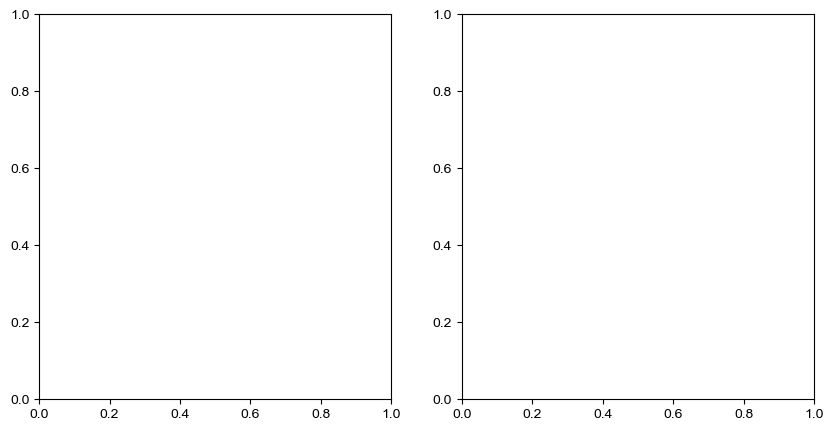

In [10]:
# Want a figure summarizing Prodigal results. Probably should have separate figures for matches and everything else, 
# and need a way to solve the fact that there are many more matches than others. Possibly add length distributions to this figure. 

def figure_1(dataset_df:pd.DataFrame):

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    palette = {'match':'darkseagreen', 'pseudogene':'lightgray', 'intergenic':'steelblue', 'conflict':'indianred'}

    ax_a_df = pd.DataFrame(index=dataset_df.category.unique())
    ax_a_df['total'] = dataset_df.category.value_counts()
    ax_a_df['log_total'] = np.log10(ax_a_df['total'])
    ax_a_df['fraction'] = dataset_df.groupby('category').apply(lambda df : df.top_hit_unsupported.sum() / len(df), include_groups=False)
    ax_a_df['unsupported'] = ax_a_df['log_total'] * ax_a_df['fraction']
    ax_a_df['confirmed'] = ax_a_df['log_totfigure_df.phase_start == figure_df.phase_stopal'] * (1 - ax_a_df['fraction'])

    positions = np.arange(dataset_df.category.nunique())
    ax_a.bar(positions, ax_a_df.unsupported, color=ax_a_df.index.map(palette), edgecolor='black', hatch='///')
    ax_a.bar(positions, ax_a_df.confirmed, bottom=ax_a_df.unsupported, color=ax_a_df.index.map(palette), edgecolor='black')

    ax_a.set_xticks(positions, labels=ax_a_df.index)
    ax_a.set_yticks(np.arange(5), labels=[f'$10^{i}$' for i in range(5)])

    for x, total, log_total in zip(positions, ax_a_df.total, ax_a_df.log_total):
        text = f'{100 * total / ax_a_df.total.sum():.2f}%'
        ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

    ax_b_df = dataset_df.copy()

    sns.kdeplot(data=ax_b_df, ax=ax_b, x='length', hue='category', palette=palette, common_norm=False)
    ax_b.set_ylabel('density')
    ax_b.set_xlim(xmin=0, xmax=800)

    text = ''
    for category, df in ax_b_df.groupby('category'):
        total = len(df)
        n_smorfs = (df.length < 100).sum()
        text += '$p_{' + category + '<100}$ = ' + f'{get_percent(n_smorfs, total)} ($n={n_smorfs}$)\n'
    ax_b.text(0.3, 0.75, text, transform=ax_b.transAxes, ha='left')
    sns.move_legend(ax_b, loc='lower right')
    ax_b.axvline(x=100, ls='--', lw=0.5, color='black')

    fig.tight_layout()
    plt.show()

figure_1(dataset_df)
# Worth noting that a sequence being registered as a conflict implies that it does not have a match, as 
# the top hit selection prioritizes overlaps which are in-frame. 


In [ ]:
def si_table_1(dataset_df:pd.DataFrame):

    table_df = pd.DataFrame(index=dataset_df.genome_id.unique())
    table_df['phylum'] = dataset_df.groupby('genome_id').phylum.first()
    table_df['gc_percent'] = dataset_df.groupby('genome_id').gc_percent.first()
    table_df['genome_size'] = dataset_df.groupby('genome_id').apply(len, include_groups=False)
    table_df['n_matches'] = dataset_df.groupby('genome_id').match.sum()
    table_df['n_unsupported_matches'] = dataset_df.groupby('genome_id').apply(lambda df : ((df.top_hit_unsupported) & df.match).sum(), include_groups=False)
    table_df['n_exact_matches'] = dataset_df.groupby('genome_id').exact_match.sum()
    table_df['n_extended'] = dataset_df.groupby('genome_id').extended.sum()
    table_df['n_truncated'] = dataset_df.groupby('genome_id').truncated.sum()
    table_df['n_pseudogenes'] = dataset_df.groupby('genome_id').pseudogene.sum()

    totals = table_df.drop(columns=['gc_percent', 'phylum']).sum(axis=0)
    for col in [col for col in totals.index if col.startswith('n_')]:
        print(col.replace('n_', '', count=1), get_percent(totals.loc[col], totals.genome_size), f'(n={totals.loc[col]})')

    for col in [col for col in table_df.columns if col.startswith('n_')]:
        table_df[col.replace('n_', '', count=1)] = [f'{n} ({get_percent(n, total)})' for n, total in zip(table_df[col], table_df.genome_size)]

    table_df = table_df.sort_values('gc_percent')
    table_df.index = table_df.index.map(dataset_df.groupby('genome_id').species.first())

    table_df.drop(columns=[col for col in table_df.columns if col.startswith('n_')])

si_table_1(dataset_df)

matches 96.51% (n=49422)
unsupported_matches 12.31% (n=6306)
exact_matches 85.68% (n=43875)
extended 6.37% (n=3264)
truncated 4.42% (n=2262)
pseudogenes 1.06% (n=543)


In [ ]:
def figure_2(results_df:pd.DataFrame):

    fig, (ax_a, ax_b) = plt.subplots(ncols=2, figsize=(10, 5))

    figure_df = results_df.copy()
    figure_df['category'] = np.select([results_df.match, results_df.pseudogene, results_df.intergenic, results_df.conflict], ['match', 'pseudogene', 'intergenic', 'conflict'], default='none')
    categories = ['match', 'conflict', 'intergenic', 'pseudogene']
    figure_df['category'] = pd.Categorical(figure_df.category, categories, ordered=True)

    width = 0.45
    offsets = {0: -width/2, 1:width/2}
    palette = {0:'indianred', 1:'darkseagreen'}

    for model_label, df in figure_df.groupby('model_label'):
        ax_df = pd.DataFrame(index=categories)
        ax_df['total'] = df.category.value_counts()
        ax_df['log_total'] = np.log10(ax_df['total'])
        ax_df['fraction'] = df.groupby('category', observed=True).apply(lambda df : df.top_hit_unsupported.sum() / len(df), include_groups=False)
        ax_df['unsupported'] = ax_df['log_total'] * ax_df['fraction']
        ax_df['confirmed'] = ax_df['log_total'] * (1 - ax_df['fraction'])

        positions = np.arange(df.category.nunique())
        ax_a.bar(positions + offsets[model_label], ax_df.unsupported, color=palette[model_label], edgecolor='black', hatch='///', width=width)
        ax_a.bar(positions + offsets[model_label], ax_df.confirmed, bottom=ax_df.unsupported, color=palette[model_label], edgecolor='black', width=width)

        for x, total, log_total in zip(positions + offsets[model_label], ax_df.total, ax_df.log_total):
            text = f'{100 * total / ax_df.total.sum():.2f}%'
            text = total
            ax_a.text(x, log_total, text, ha='center', fontsize='small', va='bottom')

    ax_a.set_xticks(positions, labels=ax_df.index)
    ax_a.set_yticks(np.arange(5), labels=[f'$10^{i}$' for i in range(5)])


    fig.tight_layout()
    plt.show()

figure_2(results_df)

# I think should probably combine these bar plots into a single chart. Although there are so many more real than spurious sequences, this might look a bit weird. 